In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import torchvision
from sklearn.metrics import roc_auc_score

### Пайплан обучения:
1. Сбор данных
2. Предобработка данных
3. Выбор архитектуры
4. Обучение модели
5. Валидация и тестирование
6. Финальная оценка на тестовой выборке

## 1. Сбор данных

In [ ]:
train = pd.read_csv('train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [ ]:
train.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

In [ ]:
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


#### Размер датасета

Датасет имеет 11 признаков.
Обучающая и тестовая выборки всодержат 58645 и 39097 объектов соответственно.


#### Описание признаков:

1. **person_age**: Возраст человека. Это числовой столбец, который указывает на возраст заемщика.

2. **person_income**: Доход человека. Это числовой столбец, который показывает годовой доход заемщика.

3. **person_home_ownership**: Информация о владении жильем. Это категориальный столбец, который может содержать значения, такие как "владелец", "арендатор" и т.д.

4. **person_emp_length**: Продолжительность работы человека. Это числовой столбец, который указывает, сколько лет человек работает на текущем месте работы.

5. **loan_intent**: Цель кредита. Это категориальный столбец, который указывает на цель, для которой был взят кредит (например, "образование", "бизнес" и т.д.).

6. **loan_grade**: Класс кредита. Это категориальный столбец, который может указывать на категорию кредита, основанную на риске (например, "A", "B", "C" и т.д.).

7. **loan_amnt**: Сумма кредита. Это числовой столбец, который указывает на общую сумму кредита.

8. **loan_int_rate**: Процентная ставка по кредиту. Это числовой столбец, который показывает процентную ставку, под которую выдан кредит.

9. **loan_percent_income**: Процент дохода, который идет на погашение кредита. Это числовой столбец, который показывает, какую часть своего дохода человек тратит на выплату по кредиту.

10. **cb_person_default_on_file**: Информация о дефолте. Это категориальный столбец, который может указывать, был ли у человека дефолт по кредиту в прошлом.
11. **cb_person_cred_hist_length**: Длина кредитной истории. Это числовой столбец, который показывает, сколько лет у человека есть кредитная история.


#### Целевой переменной является:


**loan_status**: Статус кредита. Это бинарный столбец, который указывает на то, выдан кредит или нет.
 аспектов кредитования.

## 2. Предобработка данных

### 2.1 Удаление лишних столбцов

In [ ]:
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


### 2.2 Работа с категориальными признаками

In [ ]:
obj_cols = train.dtypes[train.dtypes=='object'].index
num_cols = train.dtypes[train.dtypes!='object'].index
obj_cols

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [ ]:
train[obj_cols]

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,RENT,EDUCATION,B,N
1,OWN,MEDICAL,C,N
2,OWN,PERSONAL,A,N
3,RENT,VENTURE,B,N
4,RENT,MEDICAL,A,N
...,...,...,...,...
58640,MORTGAGE,EDUCATION,D,Y
58641,RENT,MEDICAL,C,N
58642,RENT,EDUCATION,D,N
58643,RENT,EDUCATION,A,N


In [ ]:
pd.unique(train['loan_grade'])

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

Поскольку loan_grade имеет логическую последовательность, его можно превратить в численный признак

In [ ]:
train_check = train.loc[0:10000]

# define ordinal encoding
encoder = OrdinalEncoder(categories = [['G','F','E','D','C','B','A']])

# transform data
train_check['loan_grade'] = encoder.fit_transform(train_check[['loan_grade']])

train_check.head()

<ipython-input-13-9617e2de6bac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_check['loan_grade'] = encoder.fit_transform(train_check[['loan_grade']])


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,5.0,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,4.0,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,6.0,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,5.0,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,6.0,6000,6.92,0.10,N,3,0


In [ ]:
pd.unique(train_check['loan_grade'])

array([5., 4., 6., 3., 2., 1., 0.])

In [ ]:
num_cols = list(num_cols)
num_cols.append('loan_grade')
num_cols

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'loan_status',
 'loan_grade']

In [ ]:
# define ordinal encoding
encoder = OrdinalEncoder(categories = [['G','F','E','D','C','B','A']])

# transform data
train['loan_grade'] = encoder.fit_transform(train[['loan_grade']])
test['loan_grade'] = encoder.fit_transform(test[['loan_grade']])
print(train.head())
print(test.head())

   person_age  person_income person_home_ownership  person_emp_length  \
0          37          35000                  RENT                0.0   
1          22          56000                   OWN                6.0   
2          29          28800                   OWN                8.0   
3          30          70000                  RENT               14.0   
4          22          60000                  RENT                2.0   

  loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION         5.0       6000          11.49                 0.17   
1     MEDICAL         4.0       4000          13.35                 0.07   
2    PERSONAL         6.0       6000           8.90                 0.21   
3     VENTURE         5.0      12000          11.11                 0.17   
4     MEDICAL         6.0       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0                         N      

In [ ]:
pd.unique(train['cb_person_default_on_file'])

array(['N', 'Y'], dtype=object)

In [ ]:
# define ordinal encoding
encoder = OrdinalEncoder(categories = [['N','Y']])

# transform data
train['cb_person_default_on_file'] = encoder.fit_transform(train[['cb_person_default_on_file']])
test['cb_person_default_on_file'] = encoder.fit_transform(test[['cb_person_default_on_file']])
print(train['cb_person_default_on_file'].head())
print(test['cb_person_default_on_file'].head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: cb_person_default_on_file, dtype: float64
0    0.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: cb_person_default_on_file, dtype: float64


In [ ]:
obj_cols = list(obj_cols)
obj_cols.remove('cb_person_default_on_file')
obj_cols.remove('loan_grade')
obj_cols

['person_home_ownership', 'loan_intent']

In [ ]:
for col in obj_cols:
    print(col, ': ', pd.unique(train[col]))

person_home_ownership :  ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent :  ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']


In [ ]:
dummies_train = pd.get_dummies(train[obj_cols], drop_first=True)

for col in dummies_train.columns:
    dummies_train[col]=dummies_train[col].apply(lambda x: 1 if x else 0)
dummies_train

,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,0,1,1,0,0,0,0
1,0,1,0,0,0,1,0,0
2,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,1
4,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...
58640,0,0,0,1,0,0,0,0
58641,0,0,1,0,0,1,0,0
58642,0,0,1,1,0,0,0,0
58643,0,0,1,1,0,0,0,0


In [ ]:
dummies_test = pd.get_dummies(test[obj_cols], drop_first=True)

for col in dummies_test.columns:
    dummies_test[col]=dummies_test[col].apply(lambda x: 1 if x else 0)
dummies_test

,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
39093,0,0,0,0,0,0,0,0
39094,0,0,0,1,0,0,0,0
39095,0,0,0,0,0,0,1,0
39096,0,0,0,0,0,0,1,0


In [ ]:
train = pd.concat([train.drop(columns=obj_cols), dummies_train], axis=1)
train

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,37,35000,0.0,5.0,6000,11.49,0.17,0.0,14,0,0,0,1,1,0,0,0,0
1,22,56000,6.0,4.0,4000,13.35,0.07,0.0,2,0,0,1,0,0,0,1,0,0
2,29,28800,8.0,6.0,6000,8.90,0.21,0.0,10,0,0,1,0,0,0,0,1,0
3,30,70000,14.0,5.0,12000,11.11,0.17,0.0,5,0,0,0,1,0,0,0,0,1
4,22,60000,2.0,6.0,6000,6.92,0.10,0.0,3,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,5.0,3.0,25000,15.95,0.21,1.0,10,0,0,0,0,1,0,0,0,0
58641,28,28800,0.0,4.0,10000,12.73,0.35,0.0,8,1,0,0,1,0,0,1,0,0
58642,23,44000,7.0,3.0,6800,16.00,0.15,0.0,2,1,0,0,1,1,0,0,0,0
58643,22,30000,2.0,6.0,5000,8.90,0.17,0.0,3,0,0,0,1,1,0,0,0,0


In [ ]:
test = pd.concat([test.drop(columns=obj_cols), dummies_test], axis=1)
test

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,23,69000,3.0,1.0,25000,15.76,0.36,0.0,2,0,0,1,0,1,0,0,0
1,26,96000,6.0,4.0,10000,12.68,0.10,1.0,4,0,0,0,0,0,0,1,0
2,26,30000,5.0,2.0,4000,17.19,0.13,1.0,2,0,0,1,0,0,0,0,1
3,33,50000,4.0,6.0,7000,8.90,0.14,0.0,7,0,0,1,0,0,0,0,0
4,26,102000,8.0,3.0,15000,16.32,0.15,1.0,4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,22,31200,2.0,5.0,3000,10.37,0.10,0.0,4,0,0,0,0,0,0,0,0
39094,22,48000,6.0,6.0,7000,6.03,0.15,0.0,3,0,0,0,1,0,0,0,0
39095,51,60000,0.0,6.0,15000,7.51,0.25,0.0,25,0,0,0,0,0,0,1,0
39096,22,36000,4.0,3.0,14000,15.62,0.39,1.0,4,0,0,0,0,0,0,1,0


### 2.3 Работа с пропусками

In [ ]:
nans = train.isna().sum()
nans[nans>0]

,0


In [ ]:
nans = test.isna().sum()
nans[nans>0]

,0


Прпусков нет

### 2.4 Разбиение на train и test

Решил дополнительно разбить train на тестовую и валидационную выборки для подбора гиперпараметров

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train.drop(columns=['loan_status']), train['loan_status'], shuffle=True, random_state=42, test_size=0.25)

In [ ]:
x_train.reset_index(drop=True, inplace=True)
x_valid.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)

### 2.5 Выбросы, распределение данных

Решил удалять выбросы только на x_train, чтобы можно было оценить влияние удаления выбросов

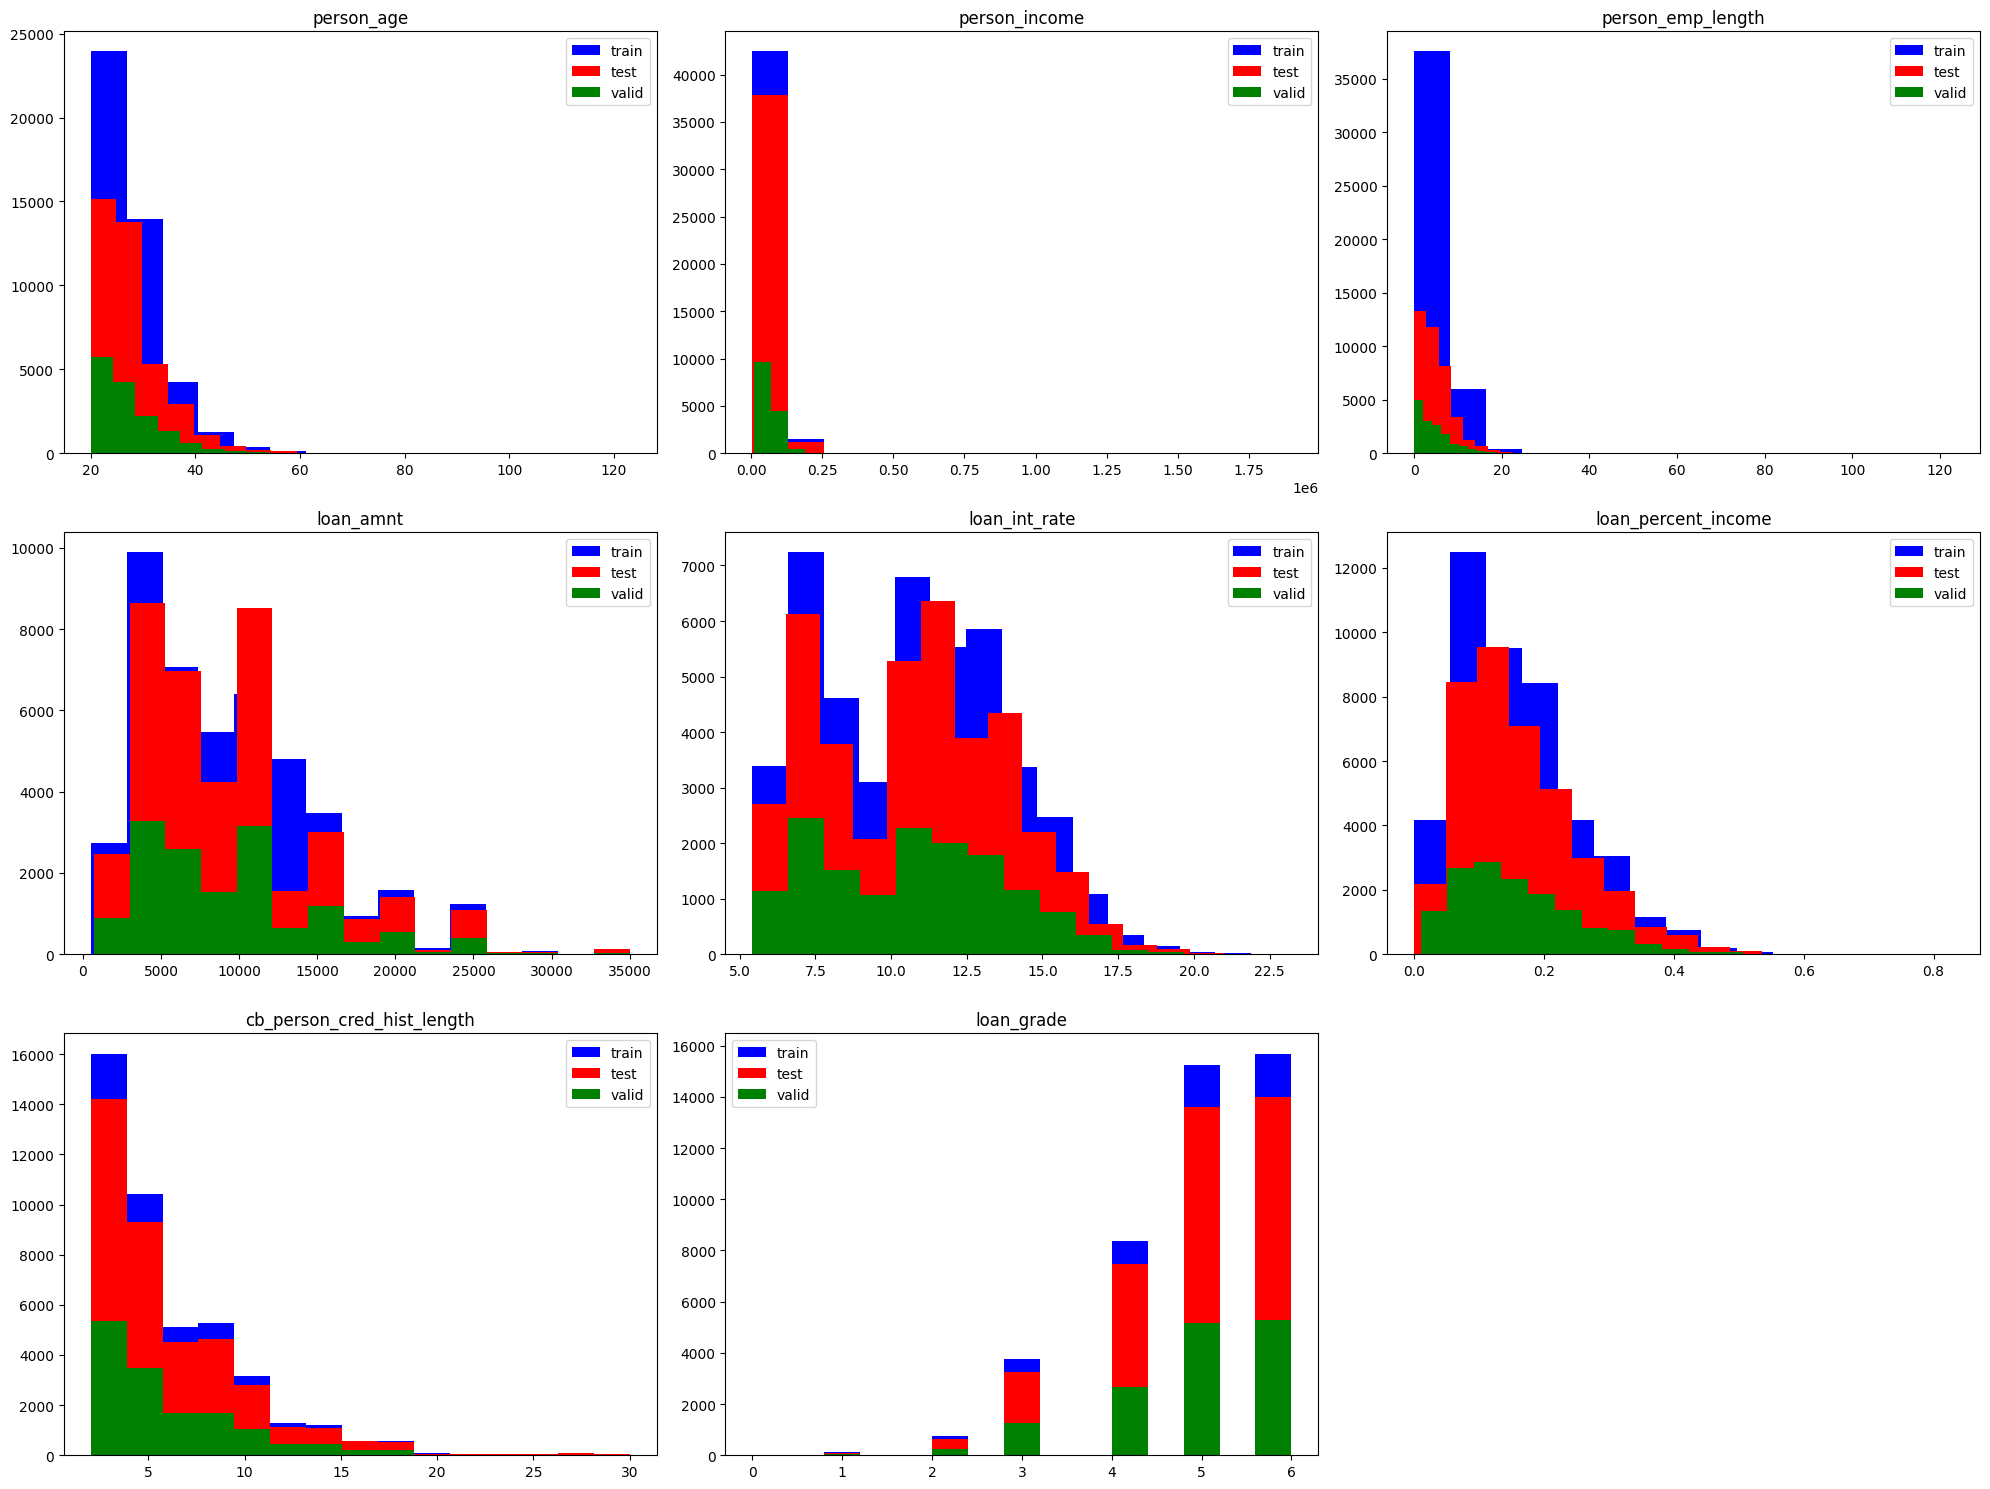

In [ ]:
plt.figure(figsize=(20,15))
num_cols.remove('loan_status')
buf=[]
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3+1, 3, i+1)
    plt.hist(x_train[col], bins=15, color='b', label='train')
    plt.hist(test[col], bins=15, color='r', label='test')
    plt.hist(x_valid[col], bins=15, color='g', label='valid')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

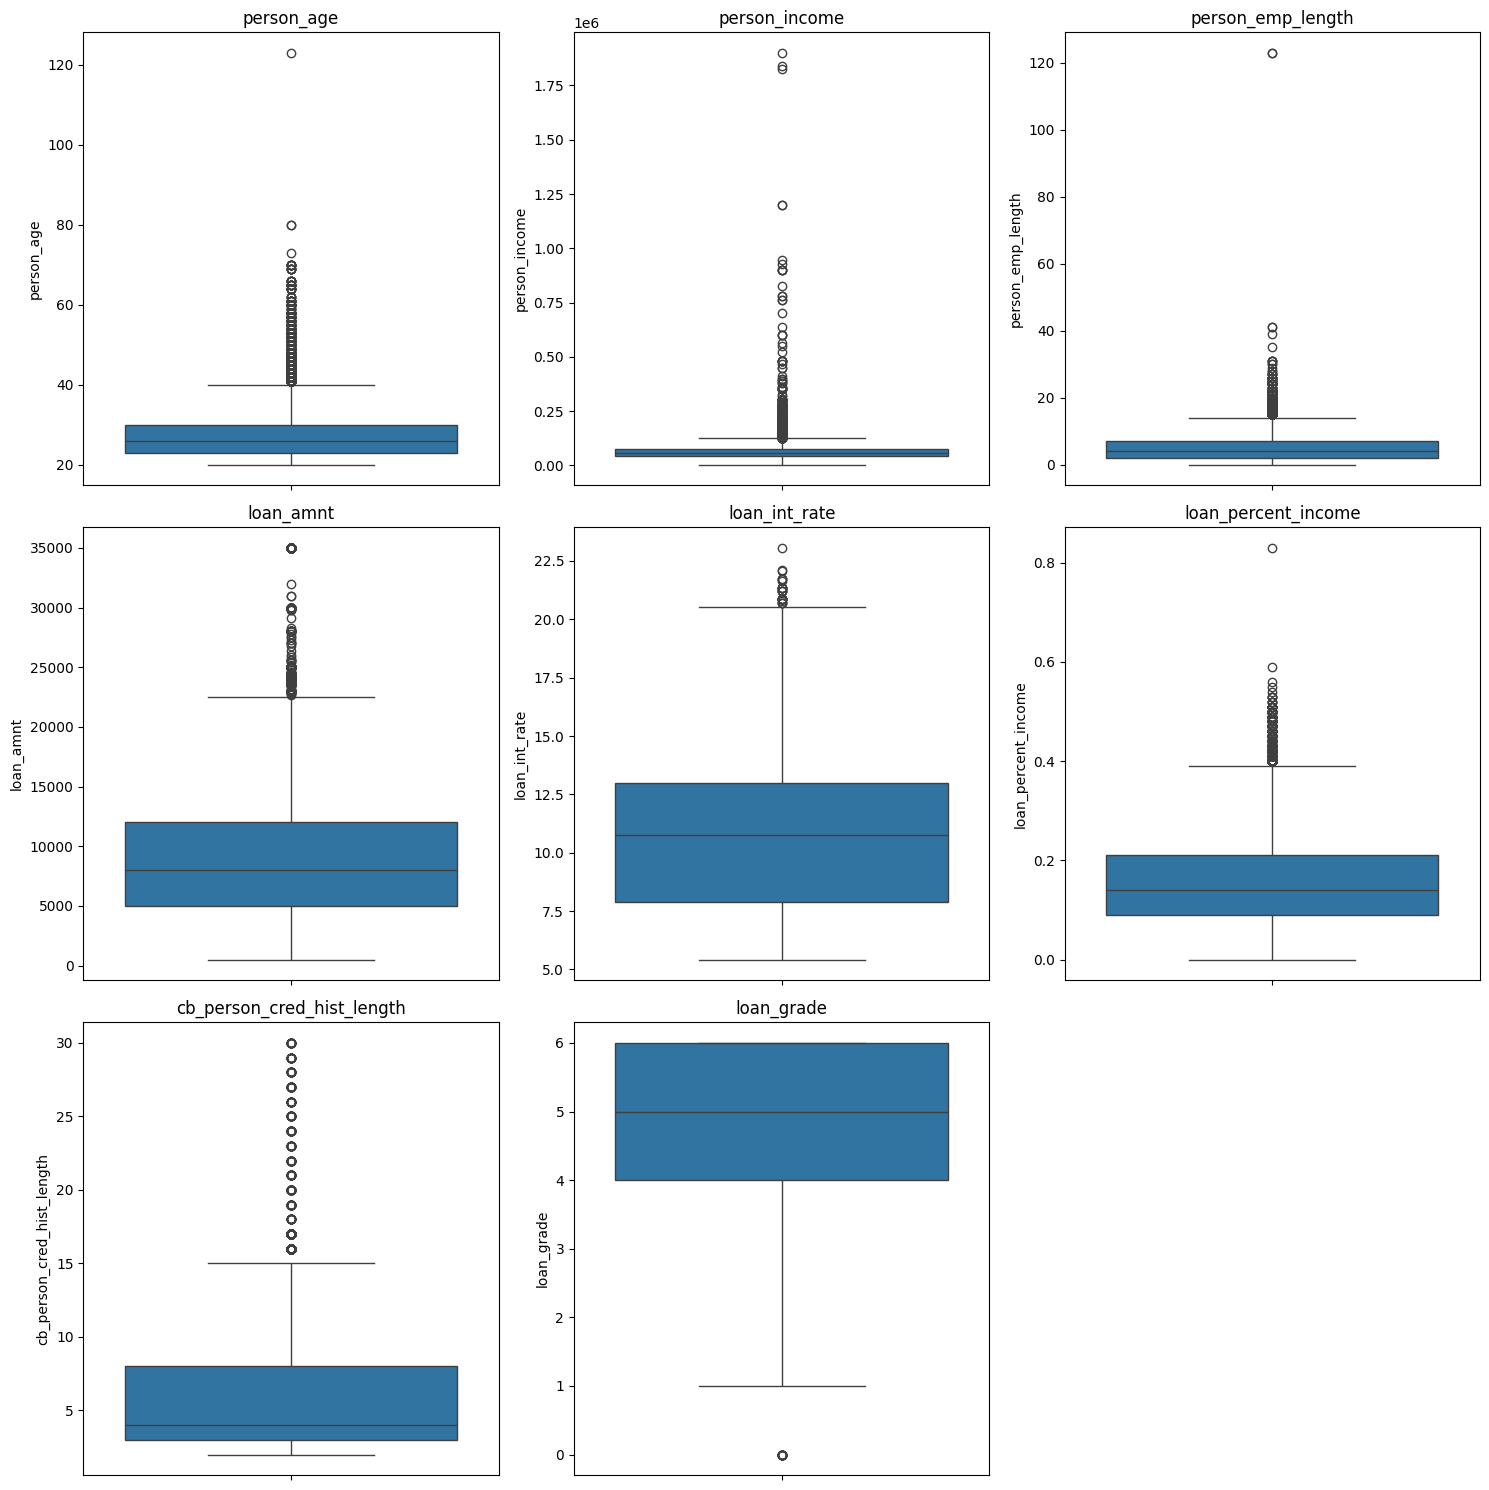

In [ ]:
plt.figure(figsize=(15,15))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3+1, 3, i+1)
    sns.boxplot(y=x_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()


В данном случае не кажется правильным удалять данные по IQR, но при этом есть слишком выбивающиеся данные, поэтому решаю воспользоваться LocalOutlierFactor, которая определяет выброс по соседям.

Проверим работу метода на person_age и person_income

In [ ]:
lof = LocalOutlierFactor()

person_age_marked = lof.fit_predict(x_train[['person_age']])
person_income_marked = lof.fit_predict(x_train[['person_income']])

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


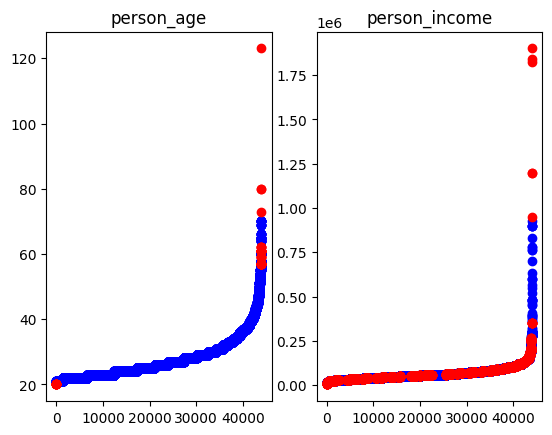

In [ ]:
person_age_marked = pd.concat([x_train[['person_age']], pd.DataFrame(person_age_marked, columns=['is_outer'])], axis=1)
person_income_marked = pd.concat([x_train[['person_income']], pd.DataFrame(person_income_marked, columns=['is_outer'])], axis=1)



plt.subplot(1,2,1)

person_age_marked_sorted = person_age_marked.sort_values(by='person_age').reset_index(drop=True)
person_age_marked_sorted_ = person_age_marked_sorted[person_age_marked_sorted['is_outer']==1]['person_age']
person_age_marked_sorted_outers = person_age_marked_sorted[person_age_marked_sorted['is_outer']==-1]['person_age']


plt.scatter(person_age_marked_sorted_.index, person_age_marked_sorted_.values, color='b')
plt.scatter(person_age_marked_sorted_outers.index, person_age_marked_sorted_outers.values, color='r')
plt.title('person_age')

plt.subplot(1,2,2)

person_income_marked_sorted = person_income_marked.sort_values(by='person_income').reset_index(drop=True)
person_income_marked_sorted_ = person_income_marked_sorted[person_income_marked_sorted['is_outer']==1]['person_income']
person_income_marked_sorted_outers = person_income_marked_sorted[person_income_marked_sorted['is_outer']==-1]['person_income']


plt.scatter(person_income_marked_sorted_.index, person_income_marked_sorted_.values, color='b')
plt.scatter(person_income_marked_sorted_outers.index, person_income_marked_sorted_outers.values, color='r')
plt.title('person_income')


plt.show()

Данный метод отмечает точки внутри основного распределения, что мне не подходит, поэтому я решил возвращать точки находящиеся внутри "усов" boxplot'a назад.

In [ ]:
person_income_marked['person_income'].iloc[-1]

np.int64(50000)

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
<ipython-input-34-82a998855971>:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Text(0.5, 1.0, 'person_income')

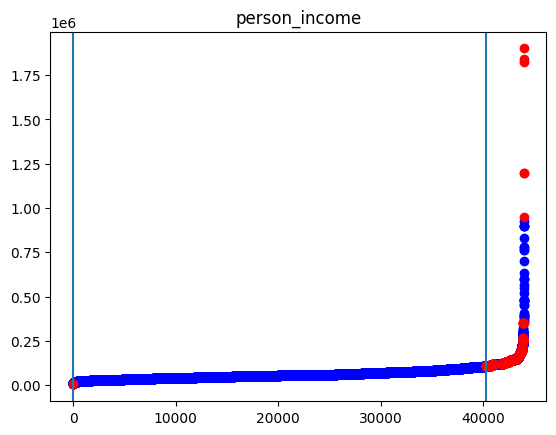

In [ ]:
lof = LocalOutlierFactor()

person_income_marked = lof.fit_predict(x_train[['person_income']])

person_income_marked = pd.concat([x_train[['person_income']], pd.DataFrame(person_income_marked, columns=['is_outer'])], axis=1)


person_income_marked_sorted = person_income_marked.sort_values(by='person_income').reset_index(drop=True)


Q3 = person_income_marked_sorted['person_income'].quantile(0.75)
Q1 = person_income_marked_sorted['person_income'].quantile(0.25)
IQR = Q3-Q1



try:
    lower_line = (person_income_marked_sorted['person_income'][person_income_marked_sorted['person_income']<(Q1-IQR)]).index[-1]
except IndexError:
    lower_line = 0

try:
    upper_line = (person_income_marked_sorted['person_income'][person_income_marked_sorted['person_income']>(Q3+IQR)]).index[0]
except IndexError:
    upper_line = len(person_income_marked_sorted)-1





person_income_marked_sorted['is_outer'][(person_income_marked_sorted['person_income']>=(Q1-IQR))&(person_income_marked_sorted['person_income']<=(Q3+IQR))] = 1

person_income_marked_sorted_ = person_income_marked_sorted[person_income_marked_sorted['is_outer']==1]['person_income']
person_income_marked_sorted_outers = person_income_marked_sorted[person_income_marked_sorted['is_outer']==-1]['person_income']


plt.scatter(person_income_marked_sorted_.index, person_income_marked_sorted_.values, color='b')
plt.scatter(person_income_marked_sorted_outers.index, person_income_marked_sorted_outers.values, color='r')



plt.axvline(lower_line)
plt.axvline(upper_line)



plt.title('person_income')





Результат все равно не очень нравится, попробую IsolationForest

<ipython-input-35-5cae219528dd>:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  person_income_marked_sorted['is_outer'][(person_income_marked_sorted['person_income']>=(Q1-IQR))&(person_income_marked_sorted['person_income']<=(Q3+IQR))] = 1


Text(0.5, 1.0, 'person_income')

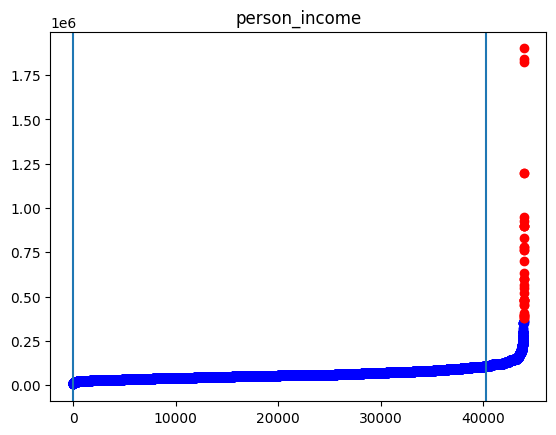

In [ ]:
if_ = IsolationForest(contamination=0.001)

person_income_marked = if_.fit_predict(x_train[['person_income']])

person_income_marked = pd.concat([x_train[['person_income']], pd.DataFrame(person_income_marked, columns=['is_outer'])], axis=1)


person_income_marked_sorted = person_income_marked.sort_values(by='person_income').reset_index(drop=True)


Q3 = person_income_marked_sorted['person_income'].quantile(0.75)
Q1 = person_income_marked_sorted['person_income'].quantile(0.25)
IQR = Q3-Q1



try:
    lower_line = (person_income_marked_sorted['person_income'][person_income_marked_sorted['person_income']<(Q1-IQR)]).index[-1]
except IndexError:
    lower_line = 0

try:
    upper_line = (person_income_marked_sorted['person_income'][person_income_marked_sorted['person_income']>(Q3+IQR)]).index[0]
except IndexError:
    upper_line = len(person_income_marked_sorted)-1





person_income_marked_sorted['is_outer'][(person_income_marked_sorted['person_income']>=(Q1-IQR))&(person_income_marked_sorted['person_income']<=(Q3+IQR))] = 1

person_income_marked_sorted_ = person_income_marked_sorted[person_income_marked_sorted['is_outer']==1]['person_income']
person_income_marked_sorted_outers = person_income_marked_sorted[person_income_marked_sorted['is_outer']==-1]['person_income']


plt.scatter(person_income_marked_sorted_.index, person_income_marked_sorted_.values, color='b')
plt.scatter(person_income_marked_sorted_outers.index, person_income_marked_sorted_outers.values, color='r')



plt.axvline(lower_line)
plt.axvline(upper_line)



plt.title('person_income')





Уже лучше, проверим на возрасте

<ipython-input-36-43acd90c3f95>:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  person_age_marked_sorted['is_outer'][(person_age_marked_sorted['person_age']>=(Q1-IQR))&(person_age_marked_sorted['person_age']<=(Q3+IQR))] = 1


Text(0.5, 1.0, 'person_age')

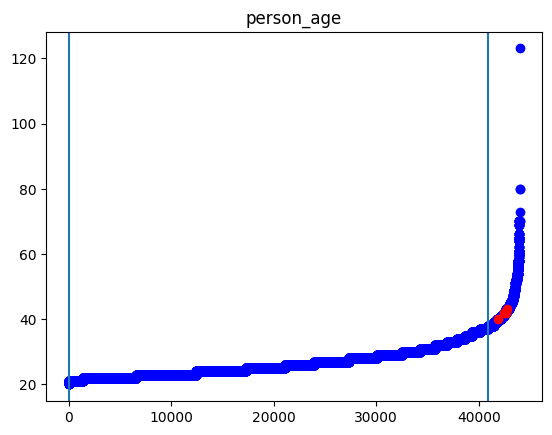

In [ ]:
if_ = IsolationForest()

person_age_marked = if_.fit_predict(x_train[['person_age']])

person_age_marked = pd.concat([x_train[['person_age']], pd.DataFrame(person_income_marked, columns=['is_outer'])], axis=1)


person_age_marked_sorted = person_age_marked.sort_values(by='person_age').reset_index(drop=True)


Q3 = person_age_marked_sorted['person_age'].quantile(0.75)
Q1 = person_age_marked_sorted['person_age'].quantile(0.25)
IQR = Q3-Q1



try:
    lower_line = (person_age_marked_sorted['person_age'][person_age_marked_sorted['person_age']<(Q1-IQR)]).index[-1]
except IndexError:
    lower_line = 0

try:
    upper_line = (person_age_marked_sorted['person_age'][person_age_marked_sorted['person_age']>(Q3+IQR)]).index[0]
except IndexError:
    upper_line = len(person_income_marked_sorted)-1





person_age_marked_sorted['is_outer'][(person_age_marked_sorted['person_age']>=(Q1-IQR))&(person_age_marked_sorted['person_age']<=(Q3+IQR))] = 1

person_age_marked_sorted_ = person_age_marked_sorted[person_age_marked_sorted['is_outer']==1]['person_age']
person_age_marked_sorted_outers = person_age_marked_sorted[person_age_marked_sorted['is_outer']==-1]['person_age']


plt.scatter(person_age_marked_sorted_.index, person_age_marked_sorted_.values, color='b')
plt.scatter(person_age_marked_sorted_outers.index, person_age_marked_sorted_outers.values, color='r')



plt.axvline(lower_line)
plt.axvline(upper_line)



plt.title('person_age')





Результат все равно не очень, поэтому просто вручную определю трешхолд и удалю по нему данные.

In [ ]:
num_cols

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'loan_grade']

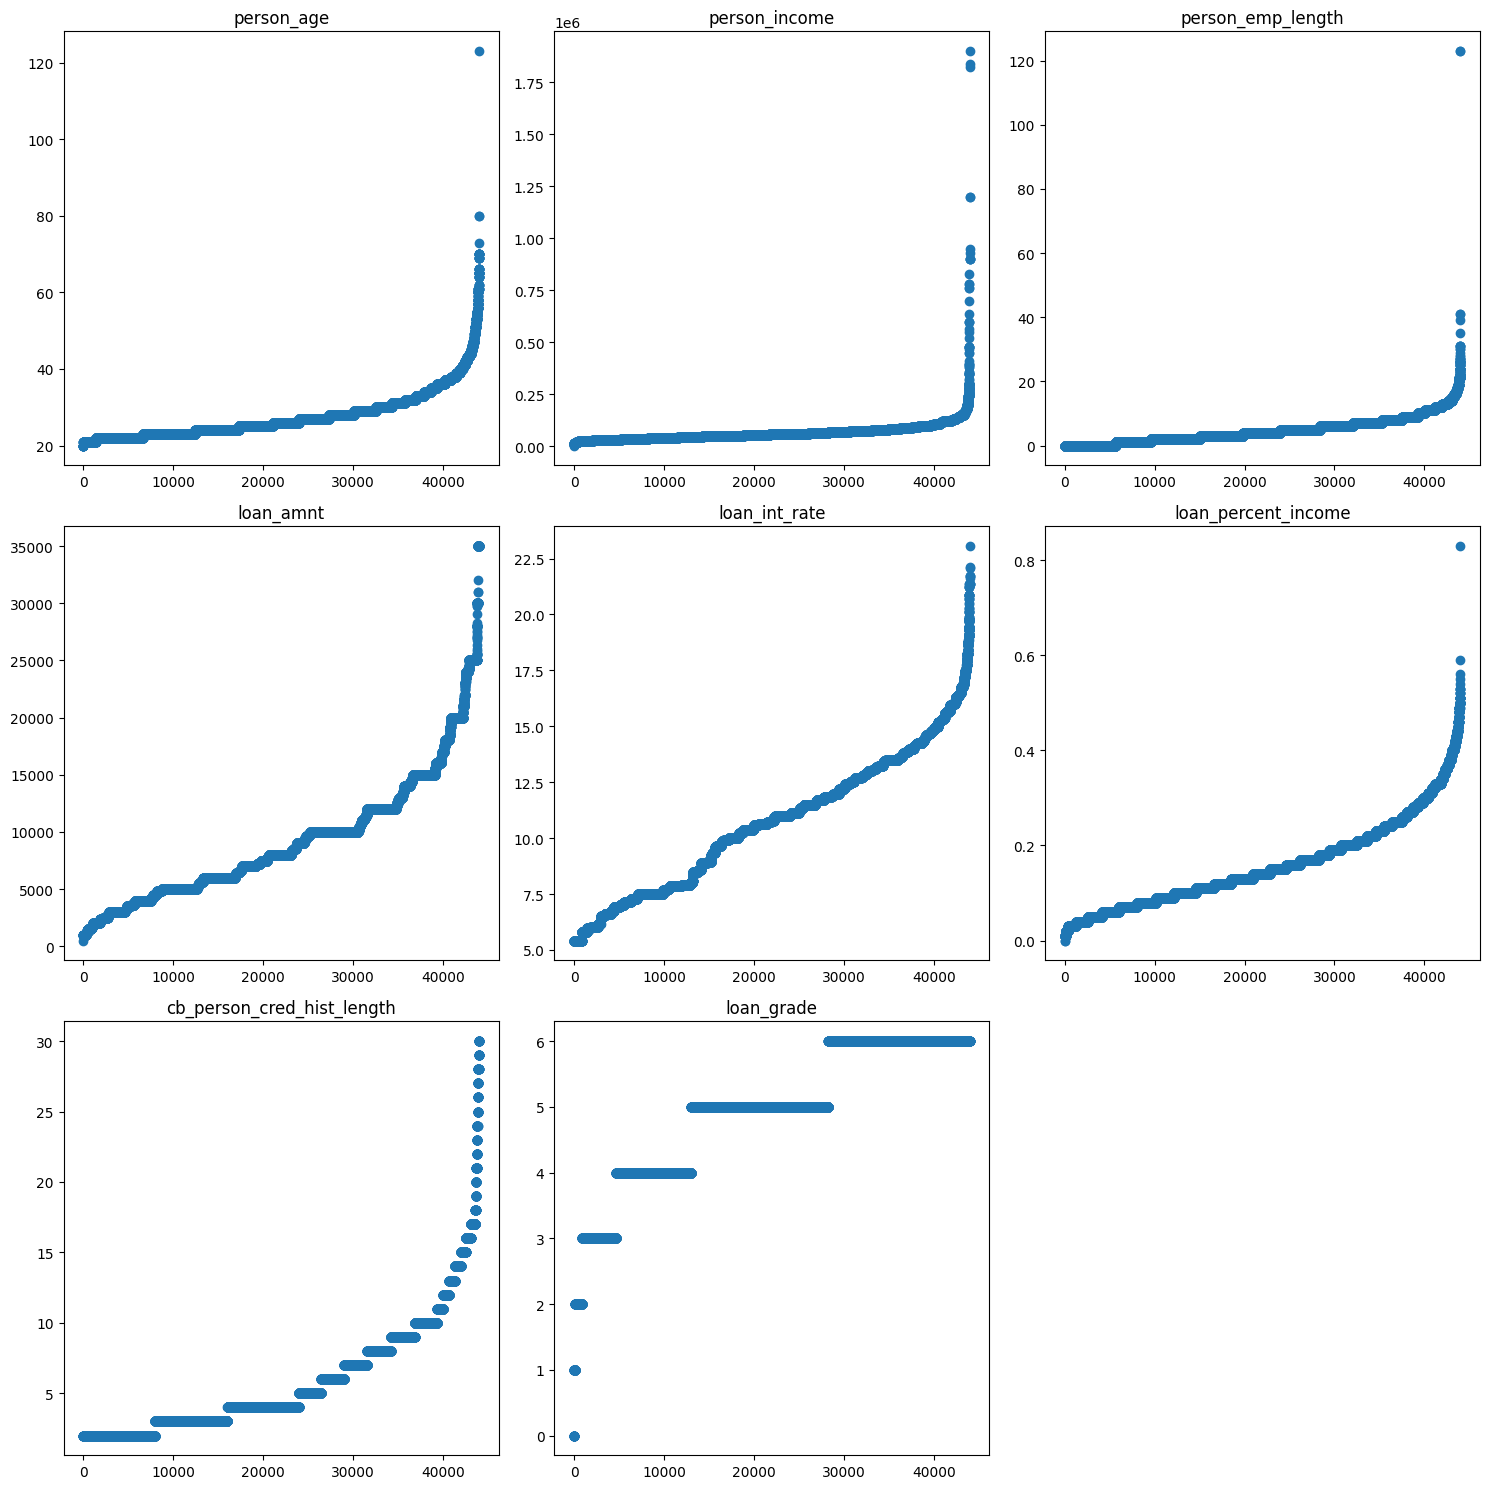

In [ ]:
plt.figure(figsize=(15,15))

for i, col in enumerate(num_cols):
    values_sorted = x_train[col].sort_values()
    values_sorted.reset_index(drop=True, inplace=True)

    plt.subplot(len(num_cols)//3+1, 3, i+1)
    plt.scatter(values_sorted.index, values_sorted.values)
    plt.title(col)

plt.tight_layout()
plt.show()


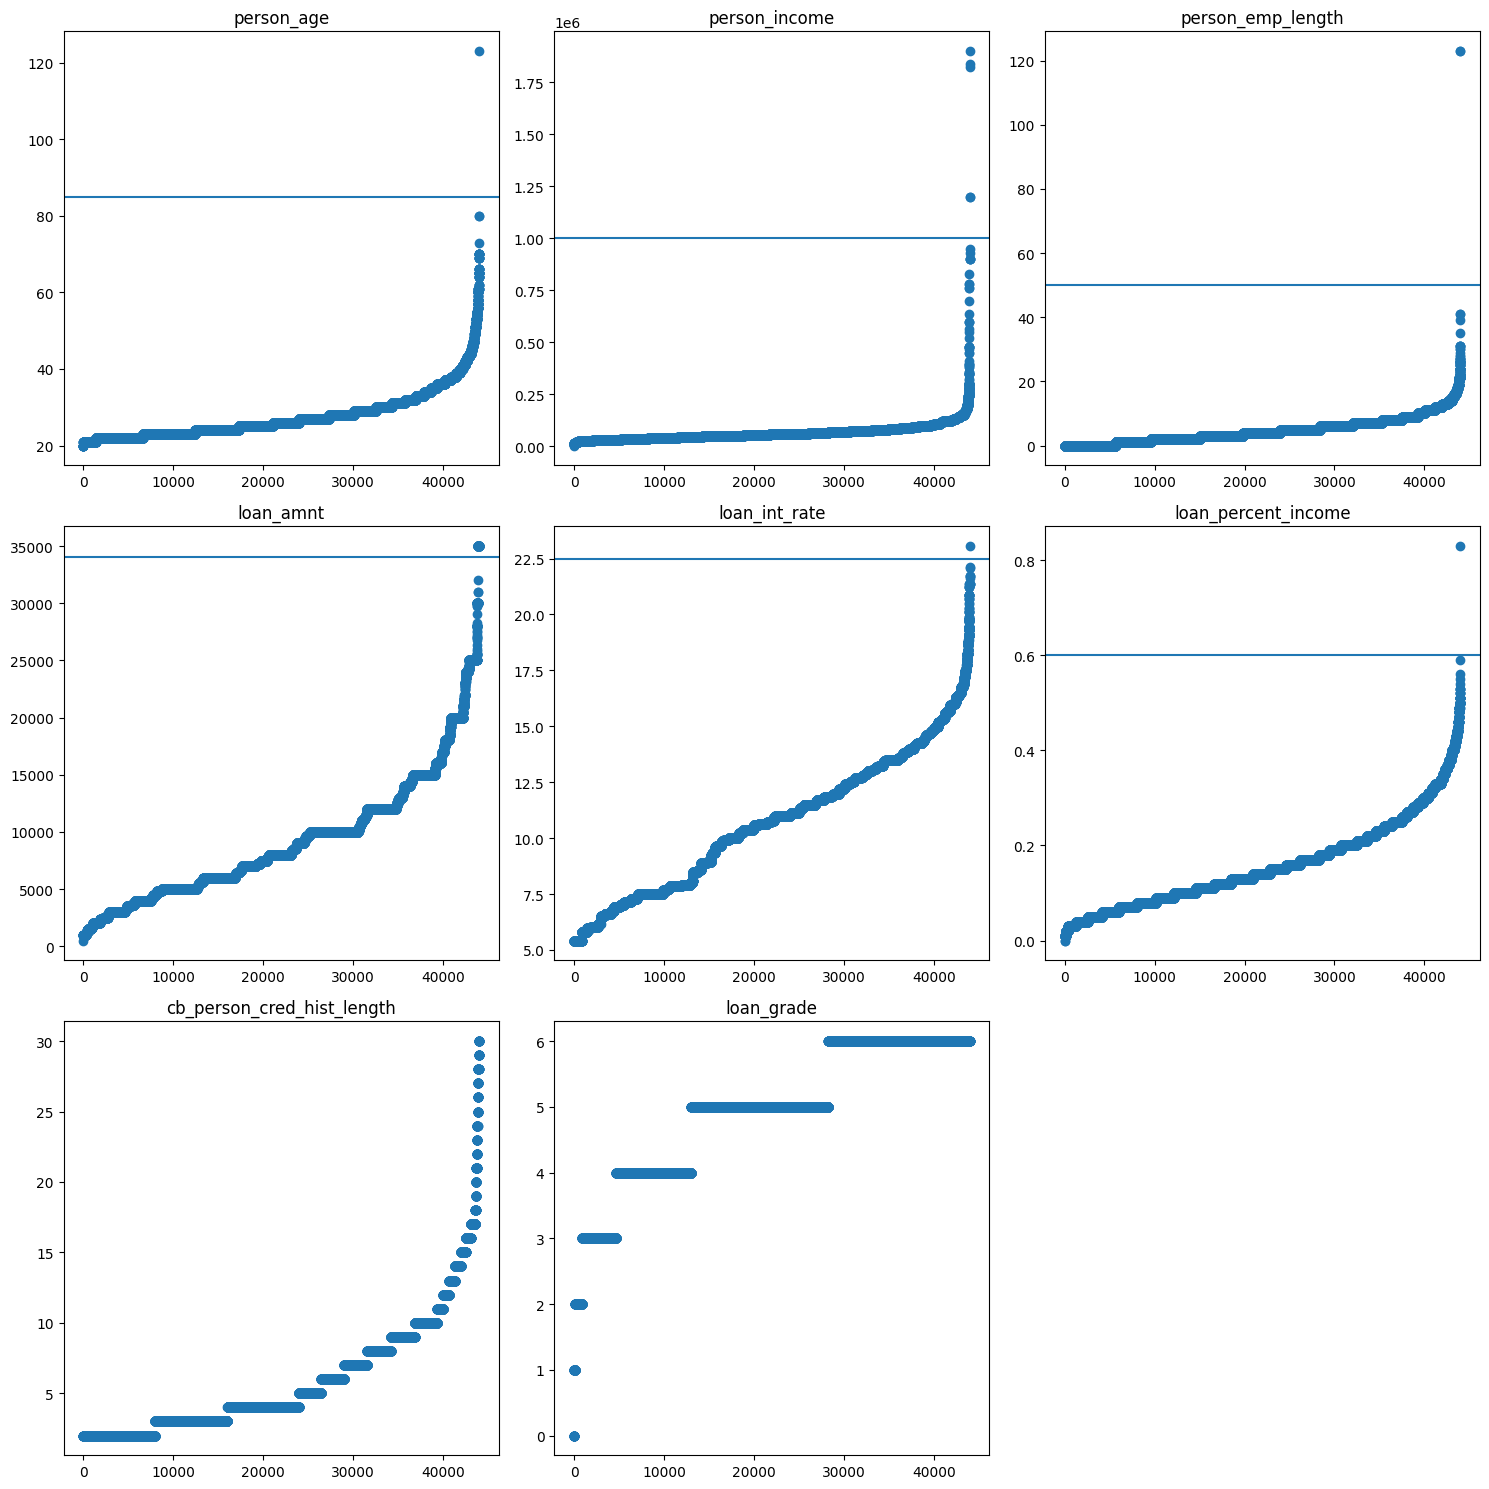

In [ ]:
plt.figure(figsize=(15,15))

lines = [85, 1e6, 50, 34000, 22.5, 0.6, False, False]

for i, col in enumerate(num_cols):
    values_sorted = x_train[col].sort_values()
    values_sorted.reset_index(drop=True, inplace=True)

    plt.subplot(len(num_cols)//3+1, 3, i+1)
    plt.scatter(values_sorted.index, values_sorted.values)

    if lines[i]:
        plt.axhline(lines[i])

    plt.title(col)



plt.tight_layout()
plt.show()


In [ ]:
bool_x_train = pd.Series(np.ones(len(x_train)))==1
print(len(x_train[bool_x_train]))

for i, col in enumerate(num_cols):
    if lines[i]:
        bool_x_train = bool_x_train & (x_train[col]<lines[i])
    print(len(x_train[bool_x_train]))


43983
43982
43977
43975
43855
43854
43853
43853
43853


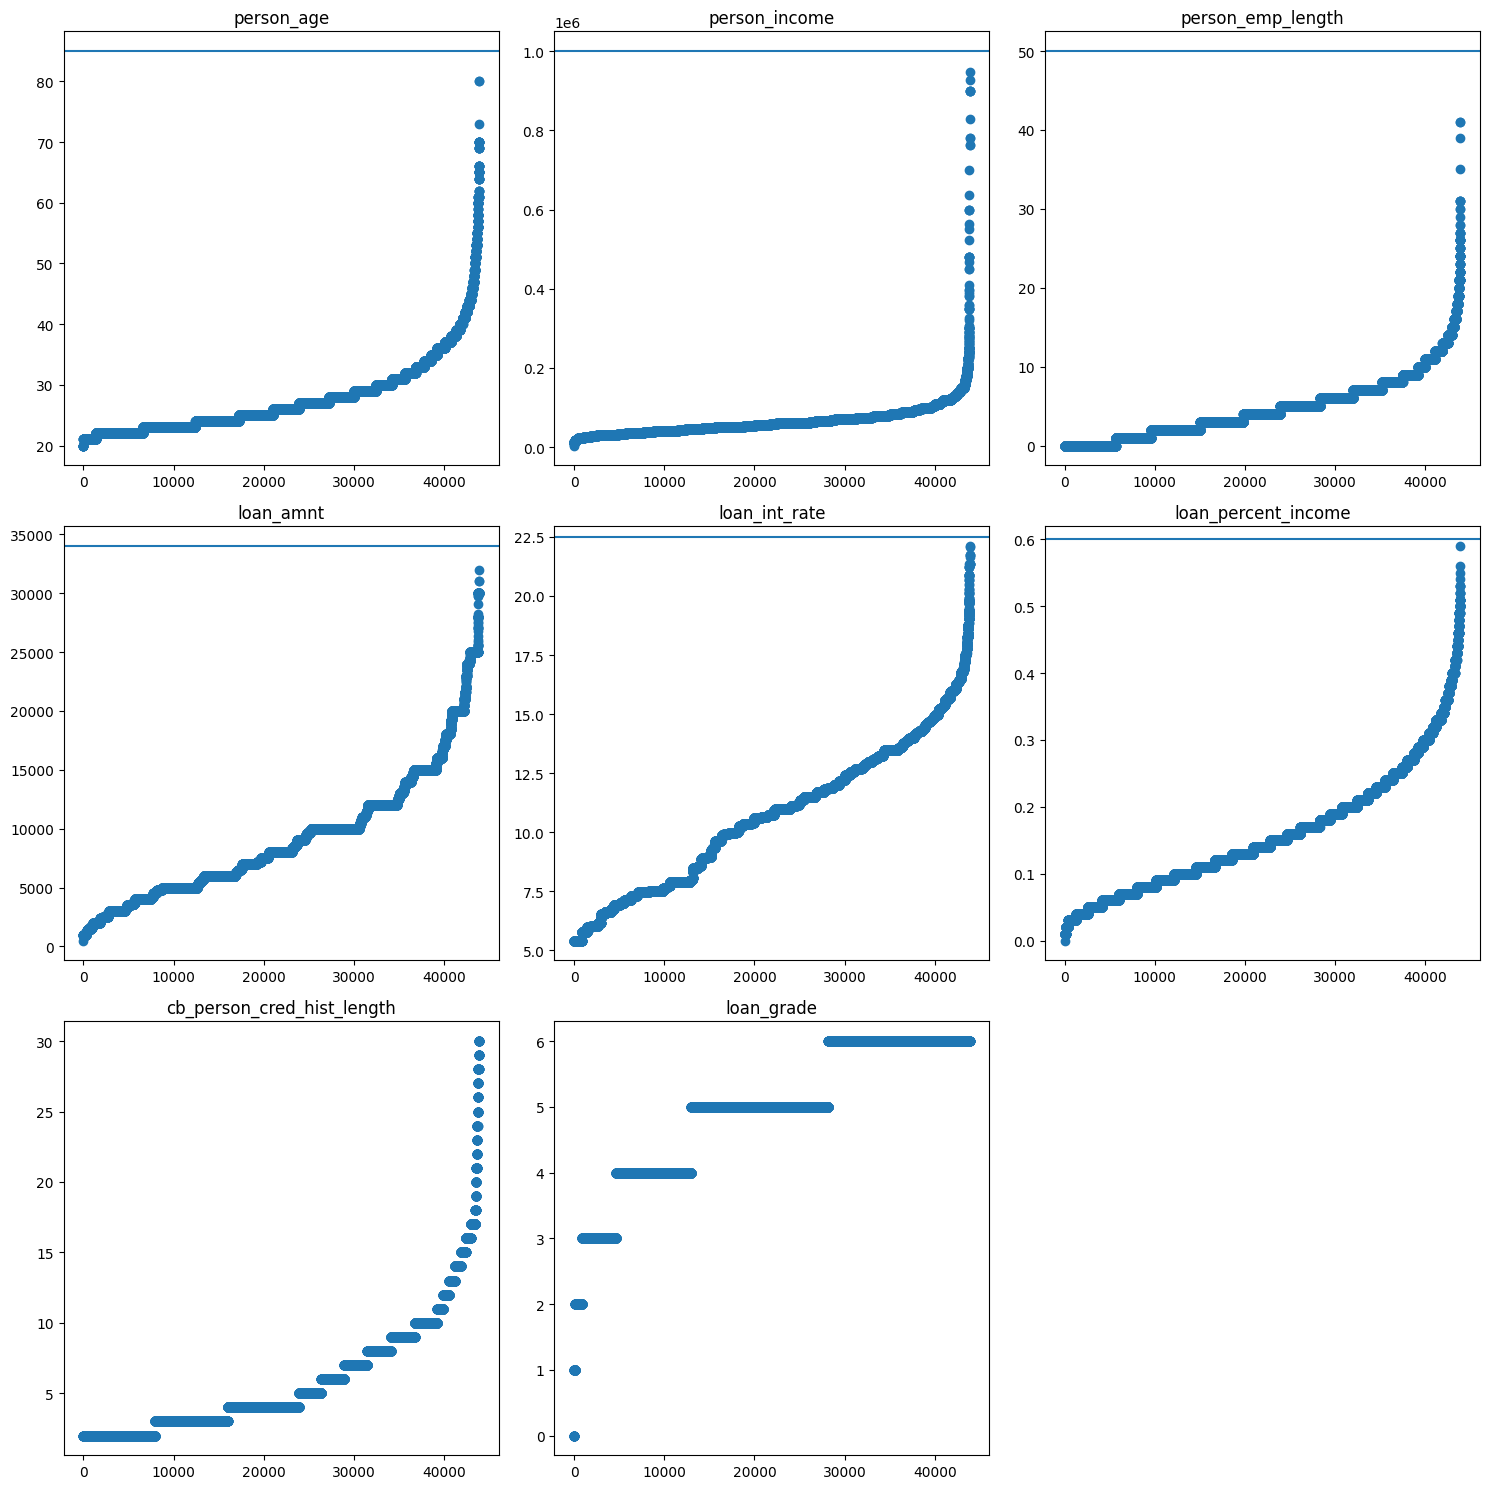

In [ ]:
plt.figure(figsize=(15,15))

x_train_cleaned = x_train[bool_x_train]
y_train_cleaned = y_train[bool_x_train]
lines = [85, 1e6, 50, 34000, 22.5, 0.6, False, False]

for i, col in enumerate(num_cols):
    values_sorted = x_train_cleaned[col].sort_values()
    values_sorted.reset_index(drop=True, inplace=True)

    plt.subplot(len(num_cols)//3+1, 3, i+1)
    plt.scatter(values_sorted.index, values_sorted.values)

    if lines[i]:
        plt.axhline(lines[i])

    plt.title(col)



plt.tight_layout()
plt.show()


In [ ]:
print(f'Удалено {(len(x_train)-len(x_train_cleaned))/len(x_train):.4f}% обучающей выборки')

Удалено 0.0030% обучающей выборки


### 2.6 Нормализция

Нормализую данные с помощью MinMaxScaler. При нормализации настраиваю скалер на обучающей выборке и применяю его ко всем, вместо нормализации всего датасета одновременно, чтобы данные из теста и валидации не проникали в обучающий датасет.

In [ ]:

scaler = MinMaxScaler()

# Подгоняем scaler на обучающем датасете
scaler.fit(x_train_cleaned)

# Применяем преобразование к обучающему датасету
x_train_cleaned_scaled = scaler.transform(x_train_cleaned)

# Применяем преобразование к валидационному датасету
x_valid_scaled = scaler.transform(x_valid)

# Применяем преобразование к тестовому датасету
test_scaled = scaler.transform(test)

x_train_cleaned_scaled = pd.DataFrame(x_train_cleaned_scaled, columns=x_train_cleaned.columns)

x_valid_scaled = pd.DataFrame(x_valid_scaled, columns=x_valid.columns)

test_scaled = pd.DataFrame(test_scaled, columns=test.columns)

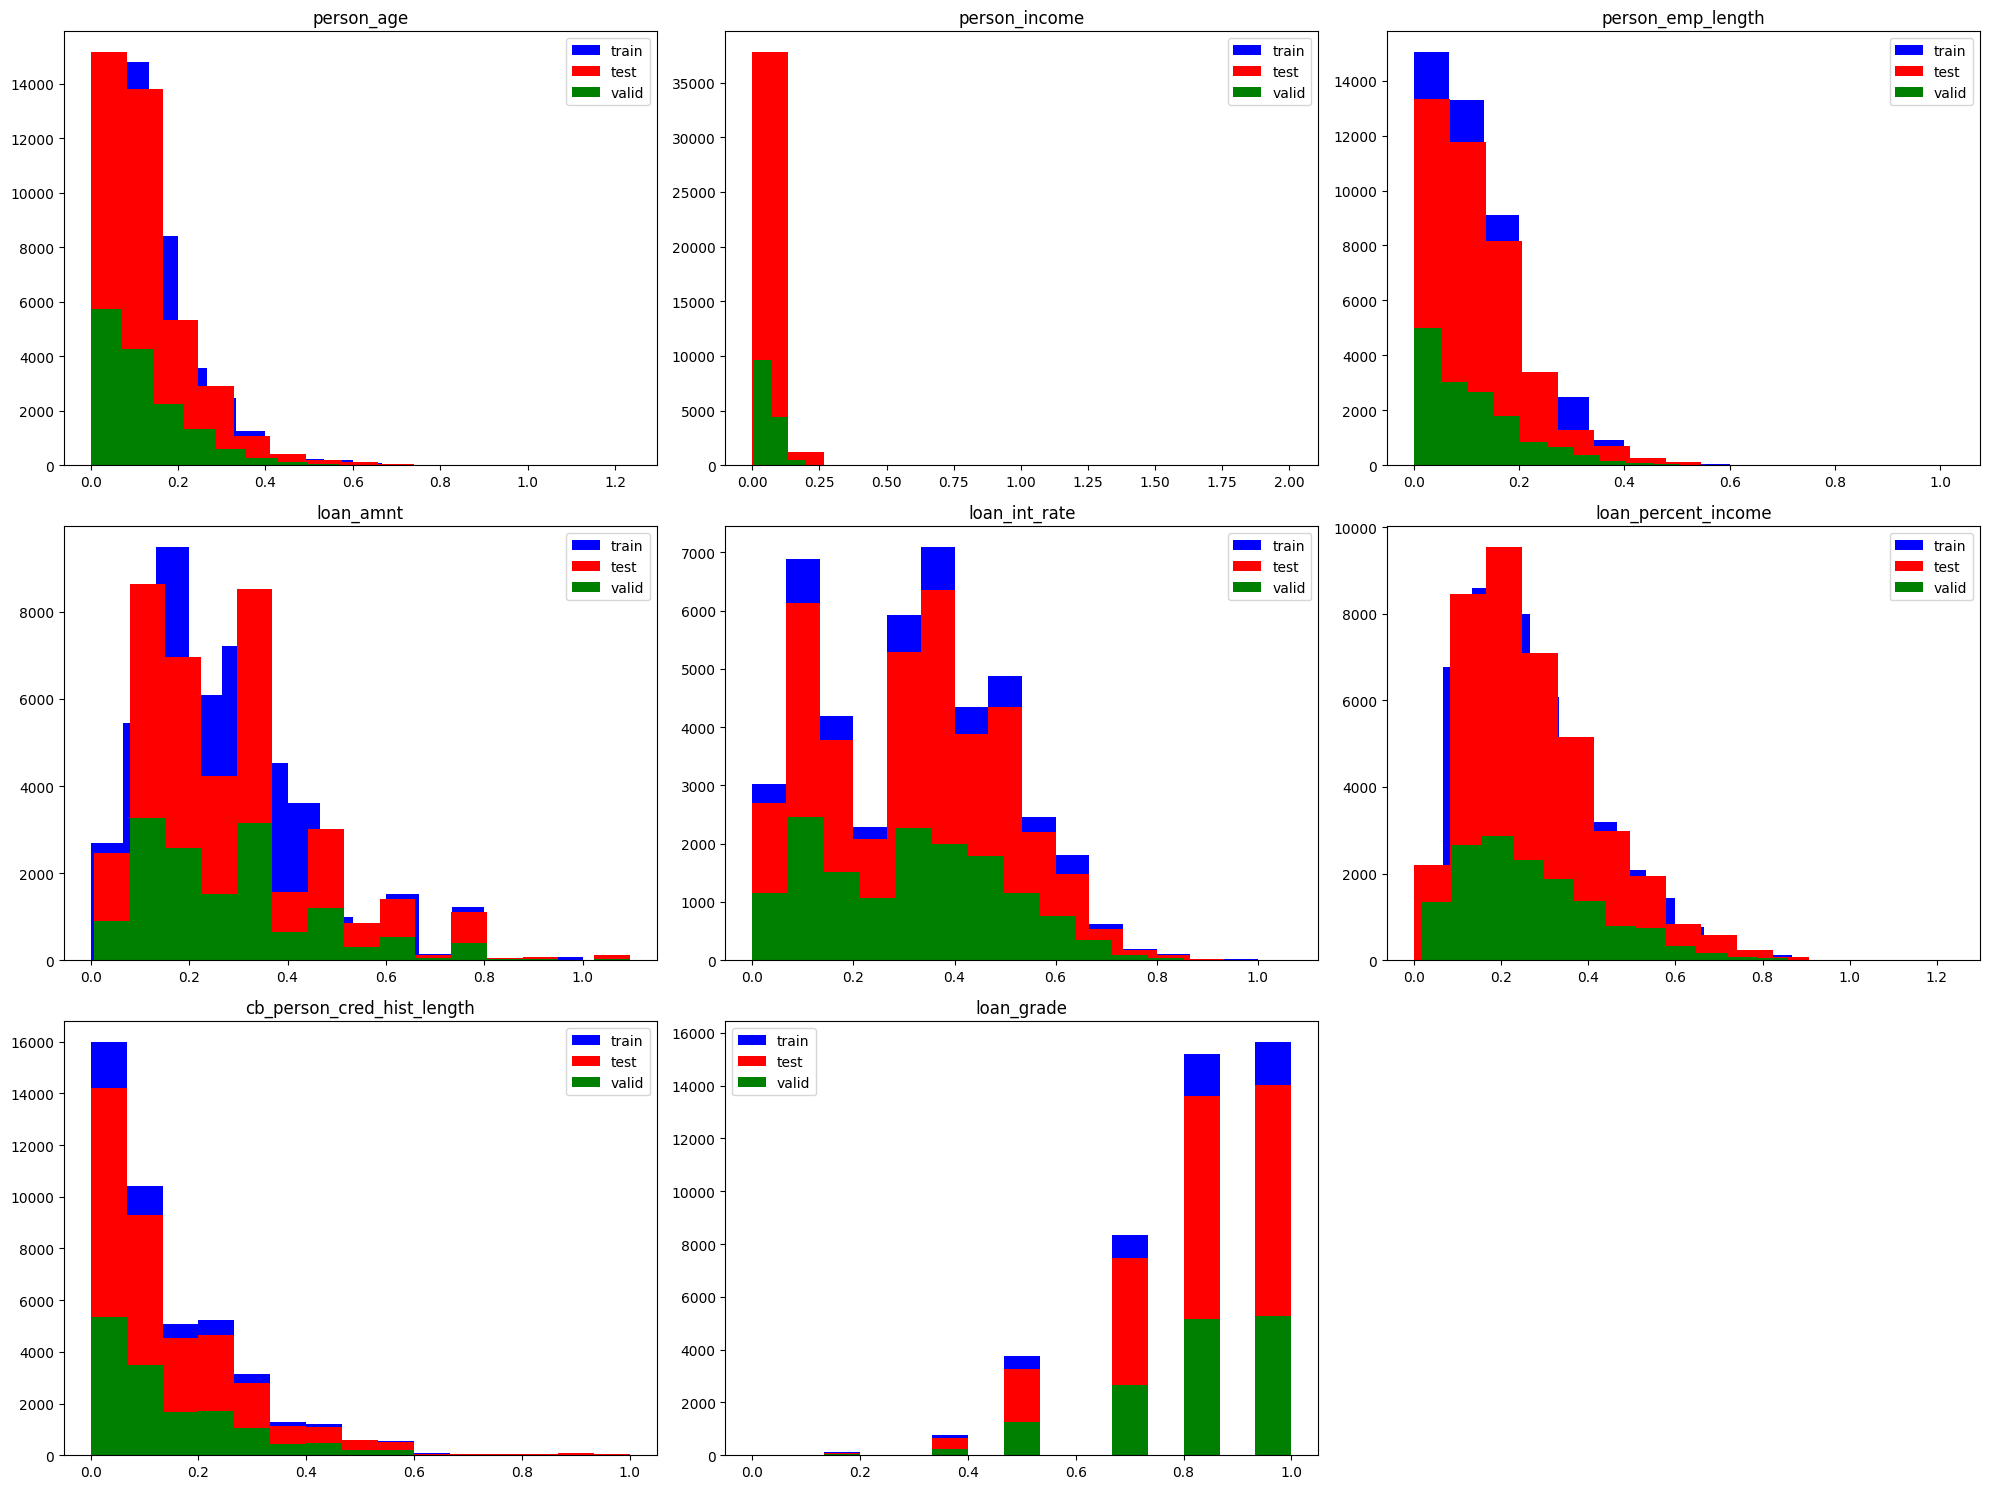

In [ ]:
plt.figure(figsize=(20,15))
buf=[]
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3+1, 3, i+1)
    plt.hist(x_train_cleaned_scaled[col], bins=15, color='b', label='train')
    plt.hist(test_scaled[col], bins=15, color='r', label='test')
    plt.hist(x_valid_scaled[col], bins=15, color='g', label='valid')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

Как мы видим - данные были отнормированы и теперь находятся в диапазоне от 0 до 1 (за редким исключением в случае тестовой и валидационной выборок, потому что они нормализовывались по обучающей)

## 3. Выбор архитектуры

В рамках этого проекта, решено использовать нейронные сети вместо решающих деревьев в обучающих целях.
Поскольку мы работаем с табличными не последовательными данными, то использую MLP - multi layer perceptron.

In [ ]:
len(x_train_cleaned_scaled.columns)

17

In [ ]:

# Создайте набор данных
class CustomDataset():
    def __init__(self, x, y):
        self.features = x.values
        self.labels = y.values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return features, label

# Создайте экземпляр набора данных
train2 = CustomDataset(x_train_cleaned_scaled, y_train_cleaned)
valid2 = CustomDataset(x_valid_scaled, y_valid)

# Создайте DataLoader
train_loader = DataLoader(train2, batch_size=8, shuffle=False)
valid_loader = DataLoader(valid2, batch_size=8, shuffle=False)

In [ ]:
class model_MLP_1(nn.Module):
    def __init__(self):
        super(model_MLP_1, self).__init__()
        self.linear1 = nn.Linear(17, 8)
        self.linear2 = nn.Linear(8, 4)
        self.linear3 = nn.Linear(4, 2)
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.flat(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.sigm(self.linear3(x))
        return x

In [ ]:
model = model_MLP_1()


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
EPOCHS = 100

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
accuracies = []
train_losses = []
test_losses = []



for i in range(EPOCHS):
    model.train()
    train_loss = []
    test_loss = []

    for data, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    accuracy = []
    model.eval()
    with torch.inference_mode():
        total_correct = 0
        total_sample = len(test_loader.dataset)
        for data, targets in test_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

            classes = torch.argmax(outputs, dim=-1)
            correct = (classes == targets).sum().item()
            total_correct += correct

    if i%10==9:
        print(f'Старт эпохи {i+1}')
        print(f'Эпоха {i+1}, accuracy: {total_correct/ total_sample:.2f}, train_loss = {np.mean(train_loss):.2f}, test_loss = {np.mean(test_loss):.2f}')

    accuracies.append(total_correct/ total_sample)
    train_losses.append(np.mean(train_loss))
    test_losses.append(np.mean(test_loss))
    try:
        if test_losses[-1] > test_losses[-10]:
            break

    except:
        pass

Старт эпохи 10
Эпоха 10, accuracy: 0.90, train_loss = 0.42, test_loss = 0.42
Старт эпохи 20
Эпоха 20, accuracy: 0.90, train_loss = 0.41, test_loss = 0.41
Старт эпохи 30
Эпоха 30, accuracy: 0.90, train_loss = 0.41, test_loss = 0.41
Старт эпохи 40
Эпоха 40, accuracy: 0.91, train_loss = 0.41, test_loss = 0.40
Старт эпохи 50
Эпоха 50, accuracy: 0.91, train_loss = 0.41, test_loss = 0.40
Старт эпохи 60
Эпоха 60, accuracy: 0.91, train_loss = 0.40, test_loss = 0.40
Старт эпохи 70
Эпоха 70, accuracy: 0.91, train_loss = 0.40, test_loss = 0.40
Старт эпохи 80
Эпоха 80, accuracy: 0.92, train_loss = 0.39, test_loss = 0.39
Старт эпохи 90
Эпоха 90, accuracy: 0.92, train_loss = 0.39, test_loss = 0.39
Старт эпохи 100
Эпоха 100, accuracy: 0.93, train_loss = 0.39, test_loss = 0.39


In [ ]:
def learning1(EPOCHS, lr, model, train_loader, valid_loader, criterion = nn.CrossEntropyLoss()):


    # Объявление переменных
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    accuracies = []
    train_losses = []
    test_losses = []
    y_pred = []
    y_true = []
    f1_scores = []


    for i in range(EPOCHS):
        model.train()
        train_loss = []
        test_loss = []

        if i%10==9:
                print(f'Старт эпохи {i+1}')


        # Обучение
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())


        # Валидация
        accuracy = []
        model.eval()
        with torch.inference_mode():
            total_correct = 0
            total_sample = len(valid_loader.dataset)
            for data, targets in valid_loader:
                outputs = model(data)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())

                classes = torch.argmax(outputs, dim=-1)
                correct = (classes == targets).sum().item()
                total_correct += correct

                y_true += list(targets)
                y_pred += list(classes)


        # Выводи матрицы ошибок в начале и в конце
        if i==0:
            cm1 = confusion_matrix(y_true, y_pred)
        if i==EPOCHS-1:
            cm2 = confusion_matrix(y_true, y_pred)

        f1 = f1_score(y_true, y_pred)
        # Вывод метрики и потерь в каждую 10-ую эпоху
        if i%10==9:
            print(f'Эпоха {i+1}, accuracy: {total_correct/ total_sample:.2f}, {str(criterion)} = {f1:.2f}\n train_loss = {np.mean(train_loss):.2f}, test_loss = {np.mean(test_loss):.2f}')

        f1_scores.append(f1)
        accuracies.append(total_correct/ total_sample)
        train_losses.append(np.mean(train_loss))
        test_losses.append(np.mean(test_loss))

        # Остановка при возрастании потерь на тестовой выборке
        try:
            if test_losses[-1] > test_losses[-10]:
                break
        except:
            pass


    print("Обучение завершено")


    # График с значением метрики и потерь в зависимости от эпохи

    plt.plot(accuracies, color='blue', label='accuracy')
    plt.plot(test_losses, color='green', label='test_loss')
    plt.plot(train_losses, color='orange', label='train_loss')

    plt.ylim(min(min(test_losses), min(train_losses)), 1)
    plt.xlabel('EPOCHS')
    plt.legend()




    plt.show
    print()
    print(f'best_test_loss: {min(test_losses)}, best_accuracy: {max(accuracies)}')
    print()
    print(classification_report(y_true, y_pred))

    return model, cm1, cm2

Старт эпохи 10
Эпоха 10, accuracy: 0.86, f1_score = 0.00
 train_loss = 0.45, test_loss = 0.44
Старт эпохи 20
Эпоха 20, accuracy: 0.90, f1_score = 0.26
 train_loss = 0.41, test_loss = 0.41
Старт эпохи 30
Эпоха 30, accuracy: 0.90, f1_score = 0.38
 train_loss = 0.41, test_loss = 0.41
Старт эпохи 40
Эпоха 40, accuracy: 0.91, f1_score = 0.44
 train_loss = 0.41, test_loss = 0.40
Старт эпохи 50
Эпоха 50, accuracy: 0.91, f1_score = 0.48
 train_loss = 0.40, test_loss = 0.40
Старт эпохи 60
Эпоха 60, accuracy: 0.91, f1_score = 0.50
 train_loss = 0.40, test_loss = 0.40
Старт эпохи 70
Эпоха 70, accuracy: 0.91, f1_score = 0.52
 train_loss = 0.40, test_loss = 0.40
Старт эпохи 80
Эпоха 80, accuracy: 0.91, f1_score = 0.53
 train_loss = 0.40, test_loss = 0.40
Старт эпохи 90
Эпоха 90, accuracy: 0.92, f1_score = 0.55
 train_loss = 0.40, test_loss = 0.40
Старт эпохи 100
Эпоха 100, accuracy: 0.92, f1_score = 0.56
 train_loss = 0.40, test_loss = 0.39
Обучение завершено

best_test_loss: 0.3933463850781622, be

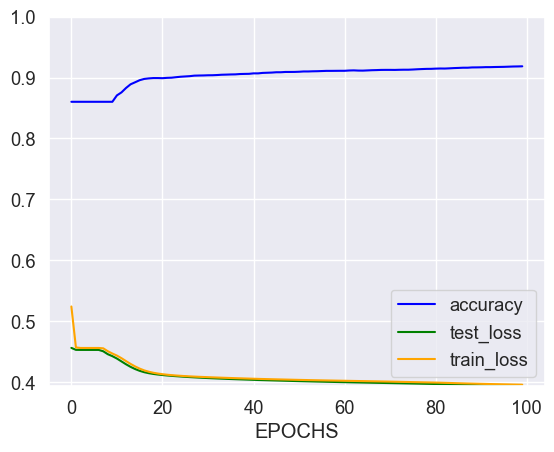

In [ ]:
model, cm1, cm2 = learning(100, 1e-4, model_MLP_1(), train_loader, valid_loader)

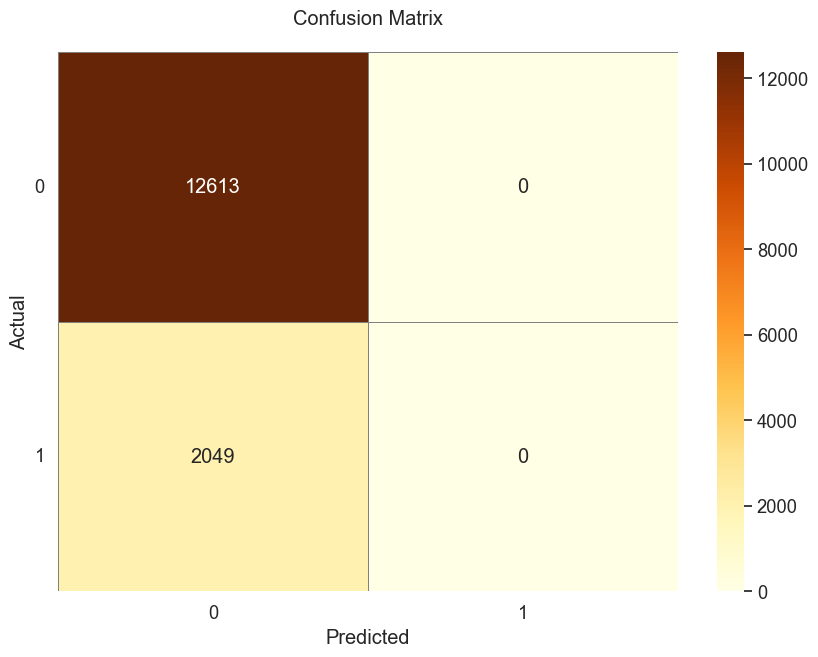

In [ ]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10, 7))
sns.heatmap(cm1, annot=True, fmt='d', cmap='YlOrBr',
            linewidths=0.5, linecolor='grey')
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()

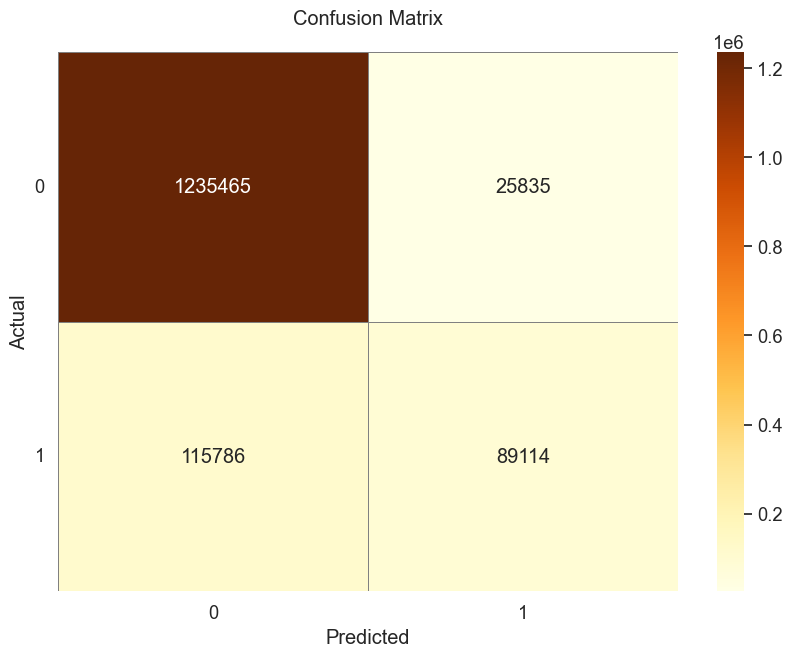

In [ ]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt='d', cmap='YlOrBr',
            linewidths=0.5, linecolor='grey')
plt.title('Confusion Matrix', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()

In [ ]:
def learning2(EPOCHS, lr, model, train_loader, valid_loader, criterion = nn.CrossEntropyLoss()):


    # Объявление переменных
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    accuracies = []
    train_losses = []
    test_losses = []
    y_pred = []
    y_true = []
    rocs = []


    for i in range(EPOCHS):
        model.train()
        train_loss = []
        test_loss = []

        if i%10==9:
                print(f'Старт эпохи {i+1}')


        # Обучение
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())


        # Валидация
        accuracy = []
        model.eval()
        with torch.inference_mode():
            total_correct = 0
            total_sample = len(valid_loader.dataset)
            for data, targets in valid_loader:
                outputs = model(data)
                loss = criterion(outputs, targets)
                test_loss.append(loss.item())

                classes = torch.argmax(outputs, dim=-1)
                correct = (classes == targets).sum().item()
                total_correct += correct

                y_true += list(targets)
                y_pred += list(classes)


        # Выводи матрицы ошибок в начале и в конце
        if i==0:
            cm1 = confusion_matrix(y_true, y_pred)
        if i==EPOCHS-1:
            cm2 = confusion_matrix(y_true, y_pred)

        roc = roc_auc_score(y_true, y_pred)
        # Вывод метрики и потерь в каждую 10-ую эпоху
        if i%10==9:
            print(f'Эпоха {i+1}, accuracy: {total_correct/ total_sample:.2f}, roc_curve = {roc:.2f}\n train_loss = {np.mean(train_loss):.2f}, test_loss = {np.mean(test_loss):.2f}')

        rocs.append(roc)
        accuracies.append(total_correct/ total_sample)
        train_losses.append(np.mean(train_loss))
        test_losses.append(np.mean(test_loss))

        # Остановка при возрастании потерь на тестовой выборке
        try:
            if test_losses[-1] > test_losses[-10]:
                break
        except:
            pass


    print("Обучение завершено")


    # График с значением метрики и потерь в зависимости от эпохи

    plt.plot(accuracies, color='blue', label='accuracy')
    plt.plot(rocs, color='red', label='roc')
    plt.plot(test_losses, color='green', label='test_loss')
    plt.plot(train_losses, color='orange', label='train_loss')

    plt.ylim(min(min(test_losses), min(train_losses)), 1)
    plt.xlabel('EPOCHS')
    plt.legend()




    plt.show
    print()
    print(f'best_test_loss: {min(test_losses)}, best_accuracy: {max(accuracies)}')
    print()
    print(classification_report(y_true, y_pred))

    return model, cm1, cm2

Старт эпохи 10
Эпоха 10, accuracy: 0.90, roc_curve = 0.57
 train_loss = 0.42, test_loss = 0.42
Старт эпохи 20
Эпоха 20, accuracy: 0.90, roc_curve = 0.64
 train_loss = 0.41, test_loss = 0.41
Старт эпохи 30
Эпоха 30, accuracy: 0.91, roc_curve = 0.67
 train_loss = 0.40, test_loss = 0.40
Старт эпохи 40
Эпоха 40, accuracy: 0.92, roc_curve = 0.69
 train_loss = 0.39, test_loss = 0.39
Старт эпохи 50
Эпоха 50, accuracy: 0.93, roc_curve = 0.71
 train_loss = 0.39, test_loss = 0.39
Старт эпохи 60
Эпоха 60, accuracy: 0.93, roc_curve = 0.73
 train_loss = 0.38, test_loss = 0.38
Старт эпохи 70
Эпоха 70, accuracy: 0.93, roc_curve = 0.74
 train_loss = 0.38, test_loss = 0.38
Старт эпохи 80
Эпоха 80, accuracy: 0.94, roc_curve = 0.75
 train_loss = 0.38, test_loss = 0.38
Старт эпохи 90
Эпоха 90, accuracy: 0.94, roc_curve = 0.75
 train_loss = 0.38, test_loss = 0.38
Старт эпохи 100
Эпоха 100, accuracy: 0.94, roc_curve = 0.76
 train_loss = 0.38, test_loss = 0.38
Обучение завершено

best_test_loss: 0.3774390511

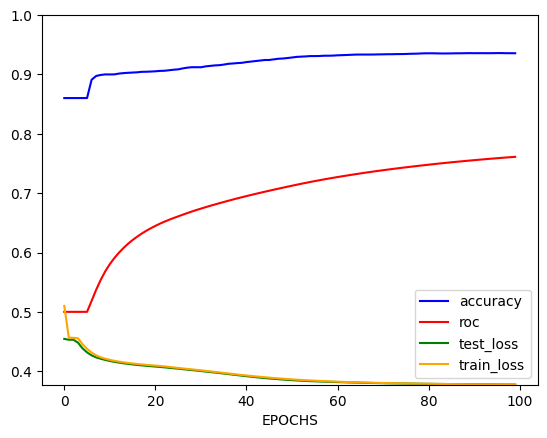

In [ ]:
model, cm1, cm2 = learning2(100, 1e-4, model_MLP_1(), train_loader, valid_loader)